### Instalation of jaqpotpy library

In [ ]:
!pip install jaqpotpy

     |████████████████████████████████| 49 kB 2.4 MB/s 
     |████████████████████████████████| 10.9 MB 8.9 MB/s 


### Essential Imports

In [ ]:
import pandas as pd
import numpy as np
from jaqpotpy import Jaqpot
from sklearn import metrics, preprocessing
from numpy.linalg import matrix_power
import requests
import json
from sklearn.preprocessing import LabelEncoder

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

### Declaration of important classes and functions

In [ ]:
class fetch_data():
  def __init__(self):
    self.trainId = 'zm22BOsxNEiGvYpdPQq4WH'
    self.testId = '8cAwj2xQpycaCC6nCQp4oe'
    self._jaqpot = Jaqpot('https://modelsbase.cloud.nanosolveit.eu/modelsbase/services/')
    self._jaqpot.request_key('guest','guest')
    

  def set_trainId(self,trainId):
    self.trainId = trainId
    return trainId
    
  def set_testId(self,testId):
    self.testId = testId
    return testId

  def get_data(self,data):
    if data=='train':
      return self._jaqpot.get_dataset(self.trainId)
    elif data=='test':
      return self._jaqpot.get_dataset(self.testId)
    else:
      raise ValueError('No such set. Please select between "train" and "test"')

  def give_data(self, path):
    if path.split('.')[-1] == 'csv':
      return pd.read_csv(path)
    elif path.split('.')[-1] == 'xlsx' or path.split('.')[-1] == 'xls':
      return pd.read_excel(path)
    else:
      raise ValueError('Unable to read file. Please provide the data manually')

In [ ]:
def regression_report(predictions,y_test):

    r2 = metrics.r2_score(y_test, predictions)
    
    k = sum(y_test*predictions)/sum(predictions**2)
    k_apostrophe = sum(y_test*predictions)/sum(y_test**2)
    
    Ro2 = 1 - sum((predictions - predictions*k)**2)/sum((predictions - np.mean(predictions))**2)
    Ro2_apostrophe =  1 - sum((y_test - y_test*k_apostrophe)**2)/sum((y_test - np.mean(y_test))**2)
    
    return({
        'correlation coef (R)': np.corrcoef(y_test, predictions)[0][1],
        'coefficient of determination (R^2)' : r2,
        'k': k,
        "k'": k_apostrophe,
        '(R2 - Ro2)/R2': (r2 - Ro2)/r2,
        "(R2 - R'o2)/R2": (r2 - Ro2_apostrophe)/r2,
        "|R2 - R'o2|": abs(r2 - Ro2_apostrophe),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_test, predictions)),
        'q2': 1 - sum((y_test - predictions)**2)/sum((y_test-np.mean(y_test))**2)
    })

In [ ]:
class NTUA_model():

  def __init__(self, X_train, X_test):
    self._X_train = X_train
    self._X_test = X_test
    self._modelId = "I6f4mcZXXjLpNiQ6HIHA"
    self._jaqpot = Jaqpot("https://modelsbase.cloud.nanosolveit.eu/modelsbase/services/")
    self._scaler = preprocessing.MinMaxScaler()
    self.doa_thresh_ = 0
    self.doa_matrix_ = None
    self._columns = ['Coating','Corresponding sphere diameter (nm)', 'Diameter  (TEM-STEM)', 'Energy Band Gap', 'Geometric Surface Area (nm2)', 'MW', 'Noxygen', 'Type of Coating \n(Anionic, Cationic, Neutral)', 'x', 'Σx/nO']
    self._encoder = LabelEncoder()
    self._encoder.classes_ = np.array(['anionic', 'cationic', 'neutral', 'uncoated'])
    self._jaqpot.request_key('guest','guest')

  def __defineDOA__(self, dataset):
    self.doa_thresh_ = 3*dataset.shape[1]/dataset.shape[0]

    dataset = np.array(dataset)

    dataset = self._scaler.fit_transform(dataset)
    
    self.doa_matrix_ = matrix_power(dataset.T@dataset, -1)

  def preprocess(self):
           
    self._X_train = self._X_train[self._columns].copy()
    self._X_test = self._X_test[self._columns].copy()

    self._X_train['Coating'][self._X_train['Coating']!='uncoated'] = 1
    self._X_train['Coating'][self._X_train['Coating']=='uncoated'] = 0

    self._X_test['Coating'][self._X_test['Coating']!='uncoated'] = 1
    self._X_test['Coating'][self._X_test['Coating']=='uncoated'] = 0

    self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'] == 'positive'] = 'cationic'
    self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'] == 'positive'] = 'cationic'

    self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'] = self._encoder.transform(self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'])
    self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'] = self._encoder.transform(self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'])

    self._X_train.rename(columns={"Type of Coating \n(Anionic, Cationic, Neutral)": "Type of Coating (Anionic, Cationic, Neutral)"}, inplace=True)
    self._X_test.rename(columns={"Type of Coating \n(Anionic, Cationic, Neutral)": "Type of Coating (Anionic, Cationic, Neutral)"}, inplace=True)
    self.__defineDOA__(self._X_train)


  def predict(self, predict_set):
    if predict_set == 'train':
      predictions = self._jaqpot.predict(self._X_train, self._modelId)
    elif predict_set == 'test':
      predictions = self._jaqpot.predict(self._X_test, self._modelId)
    else:
      predictions = ([],[])
    return np.array(predictions[0][predictions[1]])


  def predictDOA(self, doa_set):
    if doa_set == 'train':
      dataset = self._X_train.copy()
    elif doa_set == 'test':
      dataset = self._X_test.copy()
    else:
      raise ValueError('No such set. Please select between "train" and "test"')
      return

    reliability = []
    H = []
    dataset = np.array(self._scaler.transform(dataset))
    for i in range(len(dataset)):
      
      h = round(dataset[i].T @ self.doa_matrix_ @ dataset[i],4)
      if h <= self.doa_thresh_:
          reliability.append('reliable')
      else:
          reliability.append('unreliable')
    return reliability

  
  def get_set(self,name):
    if name == 'train':
      return self._X_train
    elif name == 'test':
      return self._X_test
    else:
      raise ValueError('No such set. Please select between "train" and "test"')

In [ ]:
class QSARLab_model():

  def __init__(self, X_train, X_test, y_train, y_test):
    self._X_train = X_train
    self._X_test = X_test
    self._y_train = y_train
    self._y_test = y_test
    self._modelId = "FADKIH6f5B7IEEL5rHX2"
    self._jaqpot = Jaqpot("https://modelsbase.cloud.nanosolveit.eu/modelsbase/services/")
    self._scaler = preprocessing.StandardScaler()
    self._scaler_doa = preprocessing.StandardScaler()
    self._h_k = 0
    self.doa_matrix_ = None
    self._columns = ['Diameter  (TEM-STEM)', 'Geometric Surface Area (nm2)', 'Corresponding sphere diameter (nm)', 'Σx/nO', 'Energy Band Gap', 'Coating', 'Type of Coating \n(Anionic, Cationic, Neutral)']
    self._jaqpot.request_key('guest','guest')
    

  def __defineDOA__(self, dataset, y):
    self.doa_matrix_ = matrix_power(dataset.T@dataset, -1)
    self._h_k = (3 * len(dataset.columns))/len(dataset.index)
    return

  def preprocess(self):
           
      self._X_train = self._X_train[self._columns].copy()
      self._X_test = self._X_test[self._columns].copy()

      self._X_train['Coating'][self._X_train['Coating']!='uncoated'] = 1
      self._X_train['Coating'][self._X_train['Coating']=='uncoated'] = 0

      self._X_test['Coating'][self._X_test['Coating']!='uncoated'] = 1
      self._X_test['Coating'][self._X_test['Coating']=='uncoated'] = 0

      self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'] == 'anionic'] = -1
      self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'].isin(['neutral', 'uncoated'])] = 0
      self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_train['Type of Coating \n(Anionic, Cationic, Neutral)'].isin(['cationic', 'positive'])] = 1

      self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'] == 'anionic'] = -1
      self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'].isin(['neutral', 'uncoated'])] = 0
      self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'][self._X_test['Type of Coating \n(Anionic, Cationic, Neutral)'].isin(['cationic', 'positive'])] = 1

      self._X_train.rename(columns={"Type of Coating \n(Anionic, Cationic, Neutral)": "Type of Coating (Anionic, Cationic, Neutral)"}, inplace=True)
      self._X_test.rename(columns={"Type of Coating \n(Anionic, Cationic, Neutral)": "Type of Coating (Anionic, Cationic, Neutral)"}, inplace=True)

      self._X_train = self._X_train.astype({'Coating':'int64','Type of Coating (Anionic, Cationic, Neutral)':'int64'})
      self._X_test = self._X_test.astype({'Coating':'int64','Type of Coating (Anionic, Cationic, Neutral)':'int64'})

      self.__defineDOA__(self._X_train, self._y_train)

      _train_charge = self._X_train.pop('Type of Coating (Anionic, Cationic, Neutral)')
      _test_charge = self._X_test.pop('Type of Coating (Anionic, Cationic, Neutral)')

      _train_coating = self._X_train.pop('Coating')
      _test_coating = self._X_test.pop('Coating')

      self._X_train = pd.DataFrame(self._scaler.fit_transform(self._X_train),columns = self._X_train.columns)
      self._X_test = pd.DataFrame(self._scaler.transform(self._X_test),columns = self._X_test.columns)
      
      self._X_train['Type of Coating (Anionic, Cationic, Neutral)'] = np.array(_train_charge)
      self._X_test['Type of Coating (Anionic, Cationic, Neutral)'] = np.array(_test_charge)

      self._X_train['Coating'] = np.array(_train_coating)
      self._X_test['Coating'] = np.array(_test_coating)


  def predict(self, predict_set):
    if predict_set == 'train':
      predictions = self._jaqpot.predict(self._X_train, self._modelId)
    elif predict_set == 'test':
      predictions = self._jaqpot.predict(self._X_test, self._modelId)
    else:
      predictions = ([],[])
    return np.array(predictions[0][predictions[1]])


  def predictDOA(self, doa_set):

    if doa_set == 'train':
      dataset = self._X_train.copy()
      y = self._y_train.copy()
    elif doa_set == 'test':
      dataset = self._X_test.copy()
      y = self._y_test.copy()
    else:
      raise ValueError('No such set. Please select between "train" and "test"')
      return

    h_indexes = []
    for idx in dataset.index.values:
        xi_t = np.asarray(dataset.loc[idx]).T
        xi = np.asarray(dataset.loc[idx])
        hi = np.dot(xi_t.dot(self.doa_matrix_), xi)
        h_indexes.append(hi)
    res = np.zeros(len(y))

    _predictions = self._jaqpot.predict(dataset, self._modelId)
    _predictions = np.array(_predictions[0][_predictions[1]])

    for x in range(0, len(y)):
        res[x] += np.array(y)[x]-_predictions[x]

    r = res.reshape(-1, 1)
    st_res = self._scaler_doa.fit_transform(r)

    return ['unreliable' if (h_indexes[i]>self._h_k or st_res[i][0]>3) else 'reliable' for i in range(len(dataset))]

  def get_set(self,name):
    if name == 'train':
      return self._X_train
    elif name == 'test':
      return self._X_test
    else:
      raise ValueError('No such set. Please select between "train" and "test"')
      return

In [ ]:
class NovaM_model():

  def __init__(self, X_train, X_test):
    self._X_train = X_train
    self._X_test = X_test
    self._mapper = {
      'row ID': 'id',
      'Coating': 'coating',
      'Diameter  (TEM-STEM)': 'diameter',
      'Ionic radius': 'ionicRadius',
      'Absolute electronegativity': 'absElectronegativity',
      'Σx/nO': 'sx2nO'
    }
    self._headers = {
      'Accept': 'application/json',
      'Content-Type': 'application/json'
    }
    self._api = 'https://mszeta.cloud.nanosolveit.eu/apis/restapi'
    self._post_X_train = []
    self._post_X_test = []
    self._response = {'train':{}, 'test':{}}

  def preprocess(self):
    self._X_train = self._X_train[self._mapper.keys()]
    self._X_test = self._X_test[self._mapper.keys()]

    self._X_train[self._X_train.select_dtypes(['object']).columns] = self._X_train.select_dtypes(['object']).apply(lambda x: x.str.strip())
    self._X_test[self._X_test.select_dtypes(['object']).columns] = self._X_test.select_dtypes(['object']).apply(lambda x: x.str.strip())

    self._post_X_train = self._X_train.rename(columns=self._mapper).to_dict(orient='records')      
    self._post_X_test = self._X_test.rename(columns=self._mapper).to_dict(orient='records')      
    

  def predict(self, predict_set):
    if predict_set == 'train':
      self._response[predict_set] = requests.request("POST", self._api, headers=self._headers, data=json.dumps(self._post_X_train)).json()
    elif predict_set == 'test':
      self._response[predict_set] = requests.request("POST", self._api, headers=self._headers, data=json.dumps(self._post_X_test)).json()
    else:
      raise ValueError('No such set. Please select between "train" and "test"')

    return np.array([item['prediction'] for item in self._response[predict_set]])

  def predictDOA(self, doa_set):
    if doa_set == 'train' or doa_set=='test':
      return np.array([item['apdPrediction'] for item in self._response[doa_set]])
    else:
      raise ValueError('No such set. Please select between "train" and "test"')

  def get_set(self,name):
    if name == 'train':
      return self._X_train
    elif name == 'test':
      return self._X_test
    else:
      raise ValueError('No such set. Please select between "train" and "test"')

### Import data

In [ ]:
data_generator = fetch_data()

  2022-01-02 13:33:09,156 - INFO - api key is set


In [ ]:
X_train = data_generator.get_data('train')
X_train.head()

,row ID,metal core,Coating,"Type of Coating \n(Anionic, Cationic, Neutral)",Ageing,Diameter (TEM-STEM),Shape group,Geometric Surface Area (nm2),Corresponding sphere diameter (nm),Atomic radius,Ionic radius,Xox,x,Nmetal,Noxygen,Σx,Σx/nO,MW,Group,Period,Absolute electronegativity,Energy Band Gap,Zeta (mV)
0,Row1,Ag,4% (w/v) each of polyoxyethylene glycerol trio...,neutral,Pristine,19.0,Spherical,1134.114948,19.000000,144.0,115.0,0.0,1.93,1.0,0.0,1.93,1.93,107.8682,11.0,5.0,4.440,1.46,-1.210
1,Row2,Ag2S,sulfate & PVP capped,neutral,Pristine,36.0,Agglomerated,4069.440000,36.000000,144.0,115.0,1.0,1.93,2.0,0.0,3.86,3.86,247.8000,11.0,5.0,5.358,1.20,-50.500
2,Row3,Ag,Tannic acid / sodium citrate,anionic,Pristine,47.3,spherical,7025.090600,47.300000,144.0,115.0,0.0,1.93,1.0,0.0,1.93,1.93,107.8682,11.0,5.0,5.358,1.46,-57.900
3,Row7,CeO2,HMTA,neutral,Pristine,30.8,Faceted,5691.840000,42.564879,182.0,102.0,4.0,1.12,1.0,2.0,1.12,0.56,172.1150,3.0,6.0,5.650,3.20,5.700
4,Row9,CeO2,PEG 1500,neutral,Pristine,4.5,Spherical,63.617251,4.500000,182.0,102.0,4.0,1.12,1.0,2.0,1.12,0.56,172.1150,3.0,6.0,5.650,3.20,0.024


In [ ]:
X_test = data_generator.get_data('test')
X_test.head()

,row ID,metal core,Coating,"Type of Coating \n(Anionic, Cationic, Neutral)",Ageing,Diameter (TEM-STEM),Shape group,Geometric Surface Area (nm2),Corresponding sphere diameter (nm),Atomic radius,Ionic radius,Xox,x,Nmetal,Noxygen,Σx,Σx/nO,MW,Group,Period,Absolute electronegativity,Energy Band Gap,Zeta (mV)
0,Row0,Ag,4% (w/v) each of polyoxyethylene glycerol trio...,neutral,Pristine,21.0966,Spherical,1398.217746,21.09660,144.0,115.0,0.0,1.930,1.0,0.0,1.9300,1.93000,107.8682,11.0,5.0,4.44000,1.460000,-5.520
1,Row8,CeO2,HMTA,neutral,Pristine,15.8000,Faceted,1497.840000,21.83523,182.0,102.0,4.0,1.120,1.0,2.0,1.1200,0.56000,172.1150,3.0,6.0,5.65000,3.200000,-2.200
2,Row10,CeO2,PEG 600,neutral,Pristine,6.0000,Spherical,113.097336,6.00000,182.0,102.0,4.0,1.120,1.0,2.0,1.1200,0.56000,172.1150,3.0,6.0,5.65000,3.200000,0.094
3,Row18,CeZrO2,uncoated,neutral,Pristine,4.4000,Spherical,60.821234,4.40000,182.0,102.0,4.0,1.225,1.0,4.0,1.1221,0.56105,263.3390,3.0,6.0,7.28805,0.800031,52.700
4,Row24,CeZrO2,uncoated,neutral,Pristine,4.7000,Spherical,69.397782,4.70000,182.0,102.0,4.0,1.225,1.0,4.0,1.1221,0.56105,263.3390,3.0,6.0,7.28805,0.800031,44.100


In [ ]:
y_train = np.array(X_train.pop('Zeta (mV)'))
y_test = np.array(X_test.pop('Zeta (mV)'))

rows_train = np.array(X_train['row ID'])
rows_test = np.array(X_test['row ID'])

### Run pipelines

##### *NTUA Model (Extra - Trees Regressor)*

In [ ]:
ntua = NTUA_model(X_train, X_test) 

  2022-01-02 13:33:11,893 - INFO - api key is set


In [ ]:
ntua.preprocess()

In [ ]:
ntua.get_set('train').head()

,Coating,Corresponding sphere diameter (nm),Diameter (TEM-STEM),Energy Band Gap,Geometric Surface Area (nm2),MW,Noxygen,"Type of Coating (Anionic, Cationic, Neutral)",x,Σx/nO
0,1,19.000000,19.0,1.46,1134.114948,107.8682,0.0,2,1.93,1.93
1,1,36.000000,36.0,1.20,4069.440000,247.8000,0.0,2,1.93,3.86
2,1,47.300000,47.3,1.46,7025.090600,107.8682,0.0,0,1.93,1.93
3,1,42.564879,30.8,3.20,5691.840000,172.1150,2.0,2,1.12,0.56
4,1,4.500000,4.5,3.20,63.617251,172.1150,2.0,2,1.12,0.56


In [ ]:
ntua_preds = ntua.predict('test')

  2022-01-02 13:33:15,004 - INFO - completed 10.0
  2022-01-02 13:33:16,460 - INFO - completed 100.0


##### *QSARLab Model (AdaBoostRegressor)*

In [ ]:
qsar_lab = QSARLab_model(X_train, X_test, y_train, y_test)

  2022-01-02 13:33:18,245 - INFO - api key is set


In [ ]:
qsar_lab.preprocess()

In [ ]:
qsar_lab.get_set('train').head()

,Diameter (TEM-STEM),Geometric Surface Area (nm2),Corresponding sphere diameter (nm),Σx/nO,Energy Band Gap,"Type of Coating (Anionic, Cationic, Neutral)",Coating
0,-0.416849,-0.185520,-0.374012,1.237053,-0.846215,0,1
1,-0.358255,-0.184783,-0.314778,4.003426,-0.935659,0,1
2,-0.319307,-0.184041,-0.275405,1.237053,-0.846215,-1,1
3,-0.376178,-0.184375,-0.291904,-0.726641,-0.247625,0,1
4,-0.466827,-0.185789,-0.424534,-0.726641,-0.247625,0,1


In [ ]:
qsar_lab_preds = qsar_lab.predict('test')

  2022-01-02 13:33:21,446 - INFO - completed 10.0
  2022-01-02 13:33:22,887 - INFO - completed 100.0


##### *NovaMechanics Model (K-Nearest Neighbors)*

In [ ]:
novaM = NovaM_model(X_train, X_test)

In [ ]:
novaM.preprocess()

In [ ]:
novaM.get_set('train').head()

,row ID,Coating,Diameter (TEM-STEM),Ionic radius,Absolute electronegativity,Σx/nO
0,Row1,4% (w/v) each of polyoxyethylene glycerol trio...,19.0,115.0,4.440,1.93
1,Row2,sulfate & PVP capped,36.0,115.0,5.358,3.86
2,Row3,Tannic acid / sodium citrate,47.3,115.0,5.358,1.93
3,Row7,HMTA,30.8,102.0,5.650,0.56
4,Row9,PEG 1500,4.5,102.0,5.650,0.56


In [ ]:
novaM_preds = novaM.predict('test')

### Predictions Table

In [ ]:
pd.DataFrame(np.array([y_test,ntua_preds,qsar_lab_preds, novaM_preds]).T, index=rows_test, columns=['Yobs', 'NTUA', 'QSARLab', 'NovaM'])

,Yobs,NTUA,QSARLab,NovaM
Row0,-5.520000,-3.760539,-17.597139,-1.943271
Row8,-2.200000,1.725972,1.407714,7.437798
Row10,0.094000,-0.665094,1.407714,9.948533
Row18,52.700000,41.403778,45.900000,45.021107
Row24,44.100000,41.103778,45.900000,45.195749
Row26,43.400000,39.303778,42.900000,44.317012
Row30,20.500000,19.303422,5.425556,20.374764
Row33,5.300000,-6.158384,2.578588,1.841916
Row40,-19.300000,-13.585578,-17.597139,2.685510
Row43,-21.800000,-8.118017,-4.791818,-31.671612


### Metrics Report

In [ ]:
metrics_table = pd.DataFrame([regression_report(model_pred, y_test) for model_pred in [ntua_preds,qsar_lab_preds,novaM_preds]], index=["NTUA","QSARLab","NovaM"]).T

In [ ]:
metrics_table

,NTUA,QSARLab,NovaM
correlation coef (R),0.868554,0.902632,0.831836
coefficient of determination (R^2),0.754250,0.793737,0.643399
k,1.008909,0.939843,0.823217
k',0.762391,0.861353,0.846837
(R2 - Ro2)/R2,-0.325705,-0.255223,-0.504438
(R2 - R'o2)/R2,-0.246145,-0.234085,-0.515436
|R2 - R'o2|,0.185655,0.185802,0.331631
RMSE,13.478125,12.347921,16.235815
q2,0.754250,0.793737,0.643399


### Domain of Applicability

In [ ]:
reliability = {
    'NTUA': ntua.predictDOA('test'),
    'QSARLab': qsar_lab.predictDOA('test'),
    'NovaM': novaM.predictDOA('test'),
}

pd.DataFrame(data = reliability, index = rows_test)

  2021-12-09 12:51:51,065 - INFO - completed 10.0
  2021-12-09 12:51:52,970 - INFO - completed 100.0


,NTUA,QSARLab,NovaM
Row0,reliable,reliable,reliable
Row8,reliable,reliable,reliable
Row10,reliable,reliable,reliable
Row18,reliable,reliable,reliable
Row24,reliable,reliable,reliable
Row26,reliable,reliable,reliable
Row30,reliable,reliable,reliable
Row33,reliable,reliable,reliable
Row40,reliable,reliable,reliable
Row43,reliable,reliable,reliable


### 1st Consensus Model (average prediction approach)

In [ ]:
mean_predictions = np.mean([ntua_preds,qsar_lab_preds,novaM_preds], axis=0)

In [ ]:
metrics_table = pd.DataFrame([regression_report(model_pred, y_test) for model_pred in [ntua_preds,qsar_lab_preds,novaM_preds, mean_predictions]], index=["NTUA","QSARLab","NovaM","Average"]).T

In [ ]:
metrics_table

,NTUA,QSARLab,NovaM,Average
correlation coef (R),0.868554,0.902632,0.831836,0.897894
coefficient of determination (R^2),0.754250,0.793737,0.643399,0.800799
k,1.008909,0.939843,0.823217,0.987207
k',0.762391,0.861353,0.846837,0.823527
(R2 - Ro2)/R2,-0.325705,-0.255223,-0.504438,-0.248540
(R2 - R'o2)/R2,-0.246145,-0.234085,-0.515436,-0.207358
|R2 - R'o2|,0.185655,0.185802,0.331631,0.166052
RMSE,13.478125,12.347921,16.235815,12.134688
q2,0.754250,0.793737,0.643399,0.800799


In [ ]:
pd.DataFrame(np.array([y_test,ntua_preds,qsar_lab_preds,novaM_preds,mean_predictions]).T, index=rows_test, columns=['Yobs', 'NTUA', 'QSARLab', 'NovaM', 'Average'])

,Yobs,NTUA,QSARLab,NovaM,Average
Row0,-5.520000,-3.760539,-17.597139,-1.943271,-7.766983
Row8,-2.200000,1.725972,1.407714,7.437798,3.523828
Row10,0.094000,-0.665094,1.407714,9.948533,3.563718
Row18,52.700000,41.403778,45.900000,45.021107,44.108295
Row24,44.100000,41.103778,45.900000,45.195749,44.066509
Row26,43.400000,39.303778,42.900000,44.317012,42.173597
Row30,20.500000,19.303422,5.425556,20.374764,15.034581
Row33,5.300000,-6.158384,2.578588,1.841916,-0.579293
Row40,-19.300000,-13.585578,-17.597139,2.685510,-9.499069
Row43,-21.800000,-8.118017,-4.791818,-31.671612,-14.860482


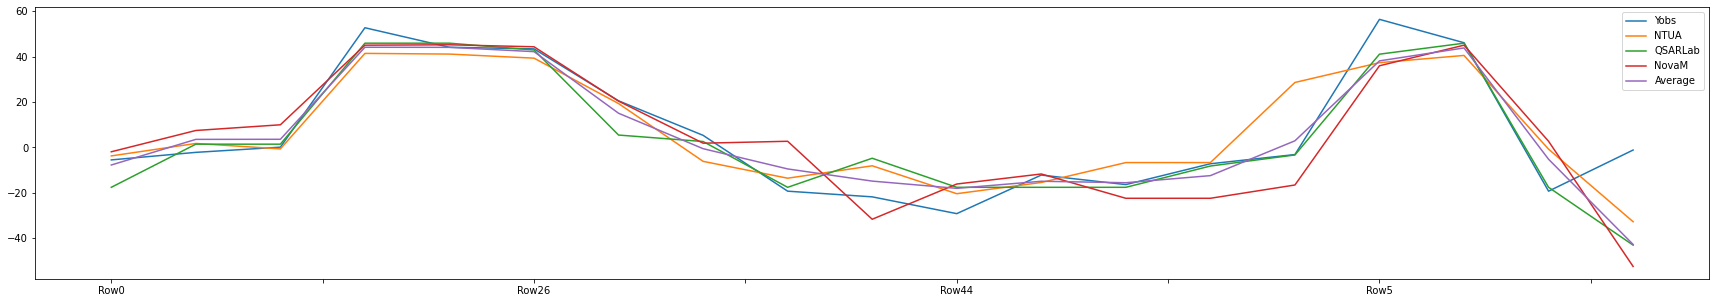

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

all = pd.DataFrame(np.array([y_test,ntua_preds,qsar_lab_preds,novaM_preds,mean_predictions]).T, index=rows_test, columns=['Yobs', 'NTUA', 'QSARLab', 'NovaM', 'Average'])
df = all
df.plot(subplots=False)
#plt.tight_layout()
plt.rcParams["figure.figsize"] = (30,5)
plt.show()

In [ ]:
# Calculating Percentage
df['NTUA2']=pd.DataFrame(df, columns = ['NTUA'])
df['NTUA2'] = 100*(df['Yobs']-df['NTUA'])/df['Yobs']

df['QSARLab2']=pd.DataFrame(df, columns = ['QSARLab'])
df['QSARLab2'] = 100*(df['Yobs']-df['QSARLab'])/df['Yobs']

df['NovaM2']=pd.DataFrame(df, columns = ['NovaM'])
df['NovaM2'] = 100*(df['Yobs']-df['NovaM'])/df['Yobs']

df['Average2']=pd.DataFrame(df, columns = ['Average'])
df['Average2'] = 100*(df['Yobs']-df['Average'])/df['Yobs']


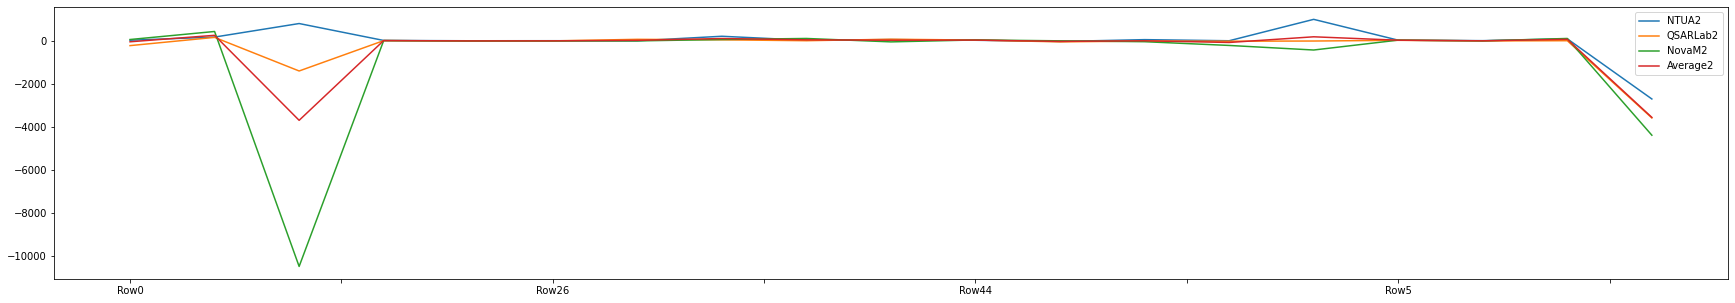

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


df2 = df[["NTUA2", "QSARLab2", "NovaM2", "Average2"]]
df2.plot(subplots=False)
#plt.tight_layout()
plt.rcParams["figure.figsize"] = (30,5)
plt.show()

### 2nd Consensus Model (MLR Model)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [ ]:
ntua_train_preds = ntua.predict('train')
qsar_lab_train_preds = qsar_lab.predict('train')
novaM_train_preds = novaM.predict('train')

  2021-12-09 12:52:09,666 - INFO - completed 10.0
  2021-12-09 12:52:11,564 - INFO - completed 100.0
  2021-12-09 12:52:18,403 - INFO - completed 10.0
  2021-12-09 12:52:20,308 - INFO - completed 100.0


In [ ]:
lm_train = pd.DataFrame(np.array([ntua_train_preds,qsar_lab_train_preds,novaM_train_preds]).T,columns=['NTUA', 'QSARLab', 'NovaM'])

In [ ]:
lm_train.head()

,NTUA,QSARLab,NovaM
0,-2.942595,-11.380000,-1.931828
1,-50.500000,-43.066667,-42.935681
2,-57.900000,-43.066667,-53.032561
3,3.706472,1.407714,5.743370
4,-1.179772,0.621667,23.902336


In [ ]:
lm_test = pd.DataFrame(np.array([ntua_preds,qsar_lab_preds, novaM_preds]).T,columns=['NTUA', 'QSARLab', 'NovaM'])

In [ ]:
lm_test.head()

,NTUA,QSARLab,NovaM
0,-3.760539,-17.597139,-1.943271
1,1.725972,1.407714,7.437798
2,-0.665094,1.407714,9.948533
3,41.403778,45.900000,45.021107
4,41.103778,45.900000,45.195749


In [ ]:
lm.fit(lm_train,y_train);
lm_train_preds = lm.predict(lm_train);
lm_preds = lm.predict(lm_test);

In [ ]:
metrics_table = pd.DataFrame([regression_report(model_pred, y_test) for model_pred in [ntua_preds,qsar_lab_preds,novaM_preds, lm_preds]], index=["NTUA","QSARLab","NovaM",'MLR']).T

In [ ]:
metrics_table

,NTUA,QSARLab,NovaM,MLR
correlation coef (R),0.868554,0.902632,0.831836,0.891466
coefficient of determination (R^2),0.754250,0.793737,0.643399,0.785208
k,1.008909,0.939843,0.823217,0.904846
k',0.762391,0.861353,0.846837,0.892012
(R2 - Ro2)/R2,-0.325705,-0.255223,-0.504438,-0.261071
(R2 - R'o2)/R2,-0.246145,-0.234085,-0.515436,-0.257740
|R2 - R'o2|,0.185655,0.185802,0.331631,0.202380
RMSE,13.478125,12.347921,16.235815,12.600618
q2,0.754250,0.793737,0.643399,0.785208


In [ ]:
pd.DataFrame(np.array([y_test,ntua_preds,qsar_lab_preds,novaM_preds,lm_preds]).T, index=rows_test, columns=['Yobs', 'NTUA', 'QSARLab', 'NovaM', 'MLR'])

,Yobs,NTUA,QSARLab,NovaM,MLR
Row0,-5.520000,-3.760539,-17.597139,-1.943271,-6.886115
Row8,-2.200000,1.725972,1.407714,7.437798,2.838082
Row10,0.094000,-0.665094,1.407714,9.948533,0.966922
Row18,52.700000,41.403778,45.900000,45.021107,48.558425
Row24,44.100000,41.103778,45.900000,45.195749,48.317387
Row26,43.400000,39.303778,42.900000,44.317012,46.034611
Row30,20.500000,19.303422,5.425556,20.374764,19.000901
Row33,5.300000,-6.158384,2.578588,1.841916,-3.658743
Row40,-19.300000,-13.585578,-17.597139,2.685510,-14.828883
Row43,-21.800000,-8.118017,-4.791818,-31.671612,-8.624901


### Comparison of all models

In [ ]:
metrics_table = pd.DataFrame([regression_report(model_pred, y_test) for model_pred in [ntua_preds,qsar_lab_preds,novaM_preds, mean_predictions, lm_preds]], index=["NTUA","QSARLab","NovaM",'Average','MLR']).T

In [ ]:
metrics_table

,NTUA,QSARLab,NovaM,Average,MLR
correlation coef (R),0.868554,0.902632,0.831836,0.897894,0.891466
coefficient of determination (R^2),0.754250,0.793737,0.643399,0.800799,0.785208
k,1.008909,0.939843,0.823217,0.987207,0.904846
k',0.762391,0.861353,0.846837,0.823527,0.892012
(R2 - Ro2)/R2,-0.325705,-0.255223,-0.504438,-0.248540,-0.261071
(R2 - R'o2)/R2,-0.246145,-0.234085,-0.515436,-0.207358,-0.257740
|R2 - R'o2|,0.185655,0.185802,0.331631,0.166052,0.202380
RMSE,13.478125,12.347921,16.235815,12.134688,12.600618
q2,0.754250,0.793737,0.643399,0.800799,0.785208


In [ ]:
pd.DataFrame(np.array([y_test,ntua_preds,qsar_lab_preds,novaM_preds,lm_preds]).T, index=rows_test, columns=['Yobs', 'NTUA', 'QSARLab', 'NovaM', 'MLR'])

,Yobs,NTUA,QSARLab,NovaM,MLR
Row0,-5.520000,-3.760539,-17.597139,-1.943271,-6.886115
Row8,-2.200000,1.725972,1.407714,7.437798,2.838082
Row10,0.094000,-0.665094,1.407714,9.948533,0.966922
Row18,52.700000,41.403778,45.900000,45.021107,48.558425
Row24,44.100000,41.103778,45.900000,45.195749,48.317387
Row26,43.400000,39.303778,42.900000,44.317012,46.034611
Row30,20.500000,19.303422,5.425556,20.374764,19.000901
Row33,5.300000,-6.158384,2.578588,1.841916,-3.658743
Row40,-19.300000,-13.585578,-17.597139,2.685510,-14.828883
Row43,-21.800000,-8.118017,-4.791818,-31.671612,-8.624901
